In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import PIL
from tensorflow.keras.preprocessing import image_dataset_from_directory
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/Shareddrives/apm_cnn_trial/trial_2/train_brand_and_model_2

acuraintegra	      chrysler300	 infinitig
acurarl		      chrysleraspen	 infinitiqx56
acuratl		      chryslercrossfire  isuzuascender
acuratsx	      chryslerpt	 jaguarxk
acurazdx	      chryslersebring	 jeepcompass
amgeneral	      chryslertown	 jeepgrand
astonmartin	      daewoonubira	 jeepliberty
audi100		      dodgecaliber	 jeeppatriot
audia5		      dodgecaravan	 jeepwrangler
audir8		      dodgechallenger	 lamborghiniaventador
audirs		      dodgecharger	 lamborghinidiablo
audis4		      dodgedakota	 lamborghinigallardo
audis5		      dodgedurango	 lamborghinireventon
audis6		      dodgejourney	 landrover
auditt		      dodgemagnum	 lincolntown
auditts		      dodgeram		 maybachlandaulet
audiv8		      dodgesprinter	 mazdatribute
bentleyarnage	      eagletalon	 mclarenmp4-12c
bentleycontinental    ferrari458	 mercedes-benz300-class
bentleymulsanne       ferraricalifornia  mercedes-benzc-class
bmw1		      ferrariff		 mercedes-benze-class
bmw3		      fiat500		 mercedes-benzs-class
bmw6		      

In [ ]:
img_height = 224
img_width = 224
batch_size = 64

train_ds = image_dataset_from_directory(
  "/content/drive/Shareddrives/apm_cnn_trial/trial_2/train_brand_and_model_2",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = image_dataset_from_directory(
  "/content/drive/Shareddrives/apm_cnn_trial/trial_2/train_brand_and_model_2",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 12948 files belonging to 157 classes.
Using 10359 files for training.
Found 12948 files belonging to 157 classes.
Using 2589 files for validation.


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras import Input, Model, optimizers, losses, metrics
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
base_model = Xception(
    include_top = False,
    weights = 'imagenet',
    input_shape = (224, 224, 3),
)

83689472/83683744 [==============================] - 1s 0us/step


In [ ]:
print("There are currently {} layers in the model.".format(len(base_model.layers)))

There are currently 132 layers in the model.


In [ ]:
for layer in base_model.layers[:110]:
  layer.trainable = False

In [ ]:
num_classes = 157
inputs = Input(shape = (224, 224, 3))
x = tf.keras.applications.xception.preprocess_input(inputs)
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)

outputs = Dense(num_classes)(x)
model = Model(inputs, outputs)

In [ ]:
callbackX = EarlyStopping(monitor='val_loss',
                          min_delta=0.001,
                          patience=10,
                          mode='auto')

model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
              loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 157)               321693    
Total params: 21,183,173
Trainable params: 8,186,061
Non-trainable params: 12,997,112
_________________________________________________________________


In [ ]:
initial_epochs = 20

initial_loss, initial_accuracy = model.evaluate(val_ds)

41/41 [==============================] - 484s 12s/step - loss: 28.0000 - accuracy: 0.0042


In [ ]:
print("initial loss: {:.3f}".format(initial_loss))
print("initial accuracy: {:.3f}".format(initial_accuracy))

initial loss: 28.000
initial accuracy: 0.004


In [ ]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    callbacks=callbackX,
                    validation_data=val_ds)

Epoch 1/20
162/162 [==============================] - 66s 407ms/step - loss: 6.2786 - accuracy: 0.0060 - val_loss: 5.0743 - val_accuracy: 0.0070
Epoch 2/20
162/162 [==============================] - 64s 395ms/step - loss: 5.0592 - accuracy: 0.0088 - val_loss: 5.0648 - val_accuracy: 0.0081
Epoch 3/20
162/162 [==============================] - 64s 393ms/step - loss: 5.0506 - accuracy: 0.0113 - val_loss: 5.0641 - val_accuracy: 0.0089
Epoch 4/20
162/162 [==============================] - 64s 393ms/step - loss: 5.0446 - accuracy: 0.0126 - val_loss: 5.0626 - val_accuracy: 0.0127
Epoch 5/20
162/162 [==============================] - 64s 394ms/step - loss: 5.0389 - accuracy: 0.0149 - val_loss: 5.0617 - val_accuracy: 0.0170
Epoch 6/20
162/162 [==============================] - 64s 393ms/step - loss: 5.0301 - accuracy: 0.0163 - val_loss: 5.0558 - val_accuracy: 0.0185
Epoch 7/20
162/162 [==============================] - 64s 394ms/step - loss: 5.0197 - accuracy: 0.0186 - val_loss: 5.0652 - val_ac

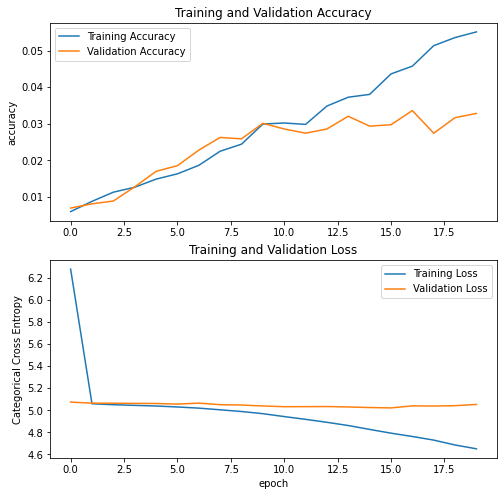

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(initial_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend(loc='best')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='best')
plt.title('Training and Validation Loss')
plt.ylabel('Categorical Cross Entropy')
plt.xlabel('epoch')
plt.show()

In [ ]:
test_ds = image_dataset_from_directory(
    '/content/drive/Shareddrives/apm_cnn_trial/trial_2/test_brand_and_model_2',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 3237 files belonging to 157 classes.


In [ ]:
test_Loss, test_accuracy = model.evaluate(test_ds)

51/51 [==============================] - 687s 13s/step - loss: 5.0138 - accuracy: 0.0303


In [ ]:
print("initial loss: {:.3f}".format(test_Loss))
print("initial accuracy: {:.3f}".format(test_accuracy))

initial loss: 5.014
initial accuracy: 0.030


In [ ]:
model.save('/content/drive/Shareddrives/apm_cnn_trial/trial_2/transfer_learning_brand_and_model/saved_models/Xception_2') 

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/Shareddrives/apm_cnn_trial/trial_2/transfer_learning_brand_and_model/saved_models/Xception_2/assets


In [ ]:
class_names = test_ds.class_names

In [ ]:
test_bmw1_path = "/content/drive/Shareddrives/apm_cnn_trial/trial_2/car_brands_test/bmw/002055.jpg"

img = tf.keras.preprocessing.image.load_img(
    test_bmw1_path, target_size=(img_height, img_width)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to chevroletsilverado with a 4.15 percent confidence.


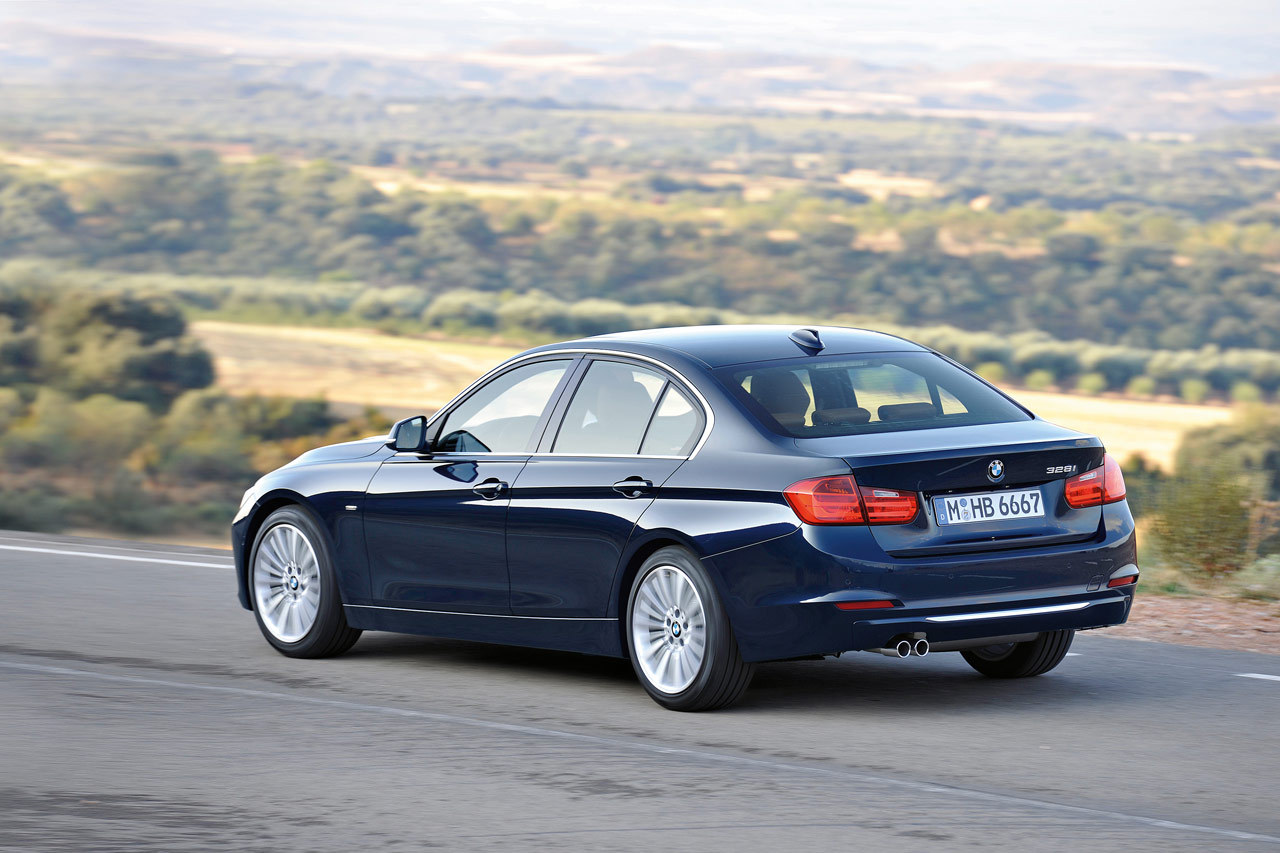

In [ ]:
PIL.Image.open('/content/drive/Shareddrives/apm_cnn_trial/trial_2/car_brands_test/bmw/002055.jpg')

In [ ]:
test_ferrari1_path = "/content/drive/Shareddrives/apm_cnn_trial/trial_2/car_brands_test/ferrari/008493.jpg"

img = tf.keras.preprocessing.image.load_img(
    test_ferrari1_path, target_size=(img_height, img_width)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to astonmartin with a 1.73 percent confidence.


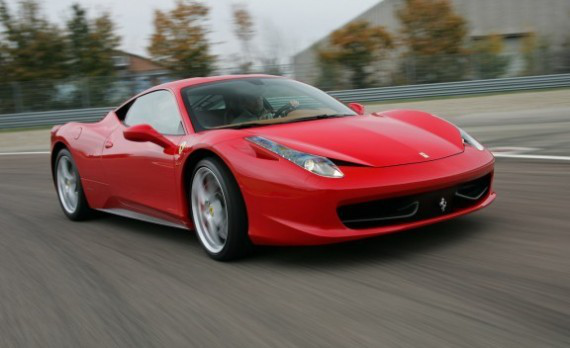

In [ ]:
PIL.Image.open('/content/drive/Shareddrives/apm_cnn_trial/trial_2/car_brands_test/ferrari/008493.jpg')

In [ ]:
sunflower_path = "/content/drive/Shareddrives/apm_cnn_trial/trial_2/car_brands_test/chevrolet/004314.jpg"

img = tf.keras.preprocessing.image.load_img(
    sunflower_path, target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = new_base_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)